In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import uproot

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Data 

In [2]:
%%time
num_feats = 19

# Load Pre-Processed Data (After Balancing)
data_train = np.loadtxt('./ttbar/train_data.txt')
feats = data_train[:,0:num_feats]
trk_label = data_train[:,-3]
trk_ID = data_train[:,-2]
event_ID = data_train[:,-1]

# Load Raw Data (Before Balacing)
data_raw = uproot.open('../refine/refined_ttbar.root:Data')
raw_feats = data_raw["features"].array(library="np")
raw_trk_label = data_raw["trk_label"].array(library="np")
useful_idx = np.where(raw_trk_label!=-999)
raw_trk_ID = data_raw["trk_ID"].array(library="np")
raw_event_ID = data_raw["Event_ID"].array(library="np")

# Convert Event IDs to zero based indices for pre-processed data
unique_trk_ID = np.unique(trk_ID)
trk_map = {j: i for i, j in enumerate(unique_trk_ID)}
trks = np.array(list(map(trk_map.get, trk_ID)))

# Convert Event IDs to zero based indices for pre-processed data
unique_trk_ID = np.unique(raw_trk_ID)
trk_map = {j: i for i, j in enumerate(unique_trk_ID)}
raw_trks = np.array(list(map(trk_map.get, raw_trk_ID)))

# Convert Event IDs to zero based indices for pre-processed data
unique_event_ID, counts = np.unique(event_ID, return_counts=True)
event_map = {j: i for i, j in enumerate(unique_event_ID)}
events = np.array(list(map(event_map.get, event_ID)))

# Convert Event IDs to zero based indices for raw data
unique_event_ID, raw_counts = np.unique(raw_event_ID, return_counts=True)
event_map = {j: i for i, j in enumerate(unique_event_ID)}
raw_events = np.array(list(map(event_map.get, raw_event_ID)))

CPU times: user 10.9 s, sys: 1.85 s, total: 12.8 s
Wall time: 14.3 s


## Issue Regarding Balancing


Due to the fact that PU is much more likely than HS, I perform very aggressive selections while balancing the dataset. If we are to represent each event as a graph, how should we deal with this imbalance in labels?

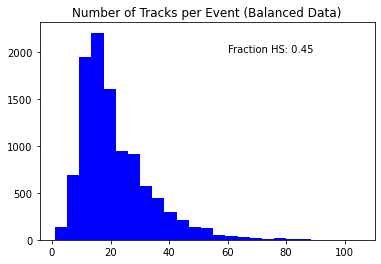

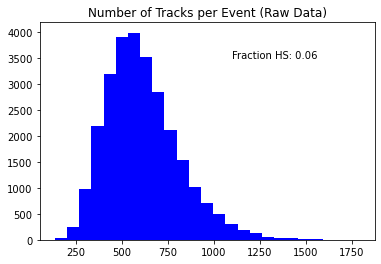

In [3]:
plt.hist(counts, bins=25, color='b')
plt.title("Number of Tracks per Event (Balanced Data)")
plt.text(60,2000,"Fraction HS: "+str(round(np.mean(trk_label),3)))
plt.show()

plt.hist(raw_counts, bins=25, color='b')
plt.title("Number of Tracks per Event (Raw Data)")
plt.text(1100,3500,"Fraction HS: "+str(round(1-np.mean(raw_trk_label[useful_idx]),3)))
plt.show()

## K-Nearest Neighbors

Lets determine the K-Nearest Neighbors for tracks. Due to the agressive balancing previously shown, there are some events with very few tracks which is throwing an error during KNN.

In [4]:
%%time
edges_per_event = []
for i in range(10):
    # Figure out which indices correspond to the event in question
    idx = np.where(events==i)
    # Use KNN on the event in question
    KNN = 16
    try:
        nbrs = NearestNeighbors(n_neighbors=KNN, algorithm='ball_tree').fit(feats[idx])
        distances, indices = nbrs.kneighbors(feats[idx])
        # Since KNN returns zero based indices, we must shift them by first index value
        indices = np.add(indices, idx[0][0])
        edges_per_event.append(indices)
    except:
        print("Event", i, "failed to find", KNN,"neighbors due to having only", len(idx[0]), "tracks!")

print()
print("For Example:\n Track", edges_per_event[0][0][0], "has the following neighbors", np.array(edges_per_event[0][0])[1:])
print()
print(edges_per_event)

Event 0 failed to find 16 neighbors due to having only 10 tracks!
Event 2 failed to find 16 neighbors due to having only 12 tracks!
Event 4 failed to find 16 neighbors due to having only 12 tracks!
Event 5 failed to find 16 neighbors due to having only 8 tracks!
Event 6 failed to find 16 neighbors due to having only 15 tracks!
Event 9 failed to find 16 neighbors due to having only 12 tracks!

For Example:
 Track 10 has the following neighbors [13 16 26 14 18 21 15 19 23 24 12 17 22 11 27]

[array([[10, 13, 16, 26, 14, 18, 21, 15, 19, 23, 24, 12, 17, 22, 11, 27],
       [11, 27, 22, 17, 12, 24, 23, 19, 15, 21, 18, 20, 25, 14, 26, 16],
       [12, 24, 17, 19, 23, 15, 21, 18, 22, 14, 11, 26, 27, 16, 20, 25],
       [13, 16, 26, 14, 10, 18, 21, 15, 19, 23, 24, 12, 17, 22, 11, 27],
       [14, 26, 18, 21, 15, 19, 23, 24, 12, 17, 22, 16, 11, 13, 27, 20],
       [15, 19, 23, 21, 18, 24, 12, 17, 22, 14, 11, 26, 27, 16, 20, 13],
       [16, 13, 26, 14, 18, 21, 15, 19, 23, 24, 12, 17, 22, 10, 11

In [5]:
# KNN isnt working with the way the uproot reads the arrays, so I manually convert...
cutoff = 10000
raw_feat = np.zeros((cutoff,num_feats))
for i in range(cutoff):
    for j in range(num_feats):
        raw_feat[i][j] = raw_feats[i][j]

In [6]:
%%time
edges_per_event = []
for i in range(10):
    # Figure out which indices correspond to the event in question
    idx = np.where(raw_events==i)
    # Use KNN on the event in question
    nbrs = NearestNeighbors(n_neighbors=16, algorithm='ball_tree').fit(raw_feat[idx])
    distances, indices = nbrs.kneighbors(raw_feat[idx])
    # Since KNN returns zero based indices, we must shift them by first index value
    indices = np.add(indices, idx[0][0])
    edges_per_event.append(indices)

print()
print("For Example:\n Track", edges_per_event[0][0][0], "has the following neighbors", np.array(edges_per_event[0][0])[1:])
print()
print(edges_per_event)


For Example:
 Track 0 has the following neighbors [ 3  2 13 16  5  4 11 12 10 14  7 15  9  6  8]

[array([[  0,   3,   2, ...,   9,   6,   8],
       [  1,   8,   6, ...,  13,   2,   3],
       [  2,  13,  16, ...,   6,   0,   8],
       ...,
       [283, 267, 271, ..., 274, 266, 261],
       [284, 262, 260, ..., 283, 267, 285],
       [285, 270, 261, ..., 282, 271, 248]]), array([[286, 294, 287, ..., 301, 306, 303],
       [287, 286, 294, ..., 305, 301, 306],
       [288, 293, 289, ..., 308, 303, 306],
       ...,
       [585, 532, 542, ..., 533, 548, 555],
       [586, 570, 584, ..., 536, 565, 583],
       [587, 563, 543, ..., 529, 536, 586]]), array([[ 588,  611,  592, ...,  613,  599,  596],
       [ 589,  604,  601, ...,  598,  603,  606],
       [ 590,  594,  598, ...,  596,  600,  595],
       ...,
       [1210, 1205, 1182, ..., 1169, 1164, 1150],
       [1211, 1207, 1198, ..., 1209, 1186, 1176],
       [1212, 1193, 1196, ..., 1159, 1145, 1205]]), array([[1213, 1227, 1223, ...,